## Klasyfikacja danych zbioru Medmnist - z elementami konkursu


## 0) Przygotowanie środowiska

In [1]:
!pip install medmnist tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=975ffe34dbb36ac60b1f1afa1c0b842498f6f5141b7ff85990605fc5da96feeb
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [2]:
import medmnist
from medmnist import INFO
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score, confusion_matrix
import tensorflow_addons as tfa
print(medmnist.__version__)
print(tf.__version__)


2.2.2
2.12.0


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## 1) Pobranie danych

In [3]:
def load_data(data_flag = 'octmnist',download = True):

    info = INFO[data_flag]
    DataClass = getattr(medmnist, info['python_class'])

    train_dataset = DataClass(split='train',  download=download)
    val_dataset = DataClass(split='val',  download=download)
    test_dataset = DataClass(split='test',  download=download)
    #train_imgs = np.concatenate((train_dataset.imgs,val_dataset.imgs),axis=0)
    #train_labels = np.concatenate((train_dataset.labels,val_dataset.labels), axis=0)

    return train_dataset, val_dataset, test_dataset

In [4]:
def show_images(train, val, test):
  fig, axs = plt.subplots(3, 3, figsize=(6, 6))

  for i in range(3):
      axs[0, i].imshow(train[i], cmap='gray')
  axs[0, 1].set_title('Przykladowe dane treningowe')

  for i in range(3):
      axs[1, i].imshow(val[i], cmap='gray')
  axs[1, 1].set_title('Przykladowe dane walidacyjne')

  for i in range(3):
      axs[2, i].imshow(test[i], cmap='gray')
  axs[2, 1].set_title('Przykladowe dane testowe')

  plt.tight_layout()
  plt.show()

100%|██████████| 54938180/54938180 [01:41<00:00, 542126.25it/s]


Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


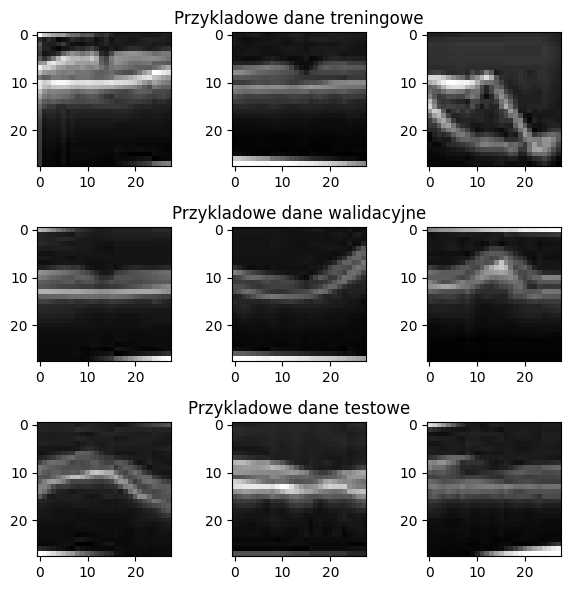

In [5]:
train, val, test = load_data()
import random

show_images(np.array(random.choices(train.imgs, k=3)), np.array(random.choices(val.imgs, k=3)), np.array(random.choices(test.imgs, k=3)))

## 2) Wstępne przetwarzanie danych

In [7]:
# Obserwujemy jak nasze klasy są zbalansowane, wychodzi na to, że nie są
print("Balans klas: ", np.unique(train.labels, return_counts=True))

Balans klas:  (array([0, 1, 2, 3], dtype=uint8), array([33484, 10213,  7754, 46026]))


In [8]:
import imgaug as ia
import imgaug.augmenters as iaa

# Decydujemy się na augmentację danych - dodajemy gaussian blur, obroty i nieznaczne zmiany jasności
def imaug_make(imgs, labels, class_nr, counts):
  images = imgs[np.argwhere(labels==class_nr).reshape(-1)]

  seq = iaa.Sequential([
      iaa.Fliplr(0.5),
      iaa.Crop(percent=(0, 0.05)),

      iaa.Sometimes(
          0.5,
          iaa.GaussianBlur(sigma=(0, 0.5))
      ),

      iaa.LinearContrast((0.95, 1.05)),

      iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),

      iaa.Multiply((0.9, 1.1), per_channel=0.2),
  ], random_order=True)
  aug = []
  for i in range(counts):
    aug.append(seq(images=images))
  aug_con = np.concatenate(aug)
  return aug_con

In [9]:
# Normalizujemy dane do przedziału [0,1]
def normalize_data(train_x, val_x, test_x):
    train_x = train_x / 255.0
    val_x = val_x / 255.0
    test_x = test_x / 255.0
    return train_x, val_x, test_x

In [10]:
# Dodatkowo enkodujemy nasze dane metodą one hot
def one_hot_encoded(train_y, val_y, test_y):
  train_y = tf.keras.utils.to_categorical(train_y, num_classes=4)
  val_y = tf.keras.utils.to_categorical(val_y, num_classes=4)
  test_y = tf.keras.utils.to_categorical(test_y, num_classes=4)
  return train_y, val_y, test_y

## 3) Klasyfikacja danych

In [11]:
# Do klasyfikacji zdecydowaliśmy się na poniższy model, który stopniowo rozbudowywaliśmy o kolejne warstwy
def model_create():
  model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(4, activation="softmax")
    ])
  return model

In [12]:
def training(train_x, train_y, val_x, val_y, epochs):
    model = model_create()
    f1_score = tfa.metrics.F1Score(num_classes=4, average='weighted')
    model.compile(optimizer="adam",
                  loss='categorical_crossentropy',
                  metrics=[f1_score])
    checkpoint_path = '/content/checkpoints/train1'
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_f1_score',
                                                 mode='max',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)
    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=epochs, callbacks=[cp_callback])
    model.load_weights(checkpoint_path)
    return model, history

In [13]:
def plot_history(history, epochs):
  acc = history.history['f1_score']
  val_acc = history.history['val_f1_score']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training f1_score')
  plt.plot(epochs_range, val_acc, label='Validation f1_score')
  plt.legend(loc='lower right')
  plt.title('Training and Validation f1_score')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

## 4) Walidacja modelu na danych testowych

In [14]:
# Walidacja modelu - f1_score oraz macierz pomyłek
def evaluate_model(test_imgs, test_labels, model):
  pred = model.predict(test_imgs)
  predictions = np.argmax(pred, axis=-1)
  test_labels = np.argmax(test_labels, axis=-1)
  f1 = f1_score(test_labels, predictions, average="weighted")
  conf = confusion_matrix(test_labels, predictions)
  print(f1)
  sns.heatmap(conf, annot=True, cmap='Blues',fmt='')
  return f1

In [15]:
# W tym momencie zaczynamy właściwą część eksperymentu
# Pobieramy dane
train, val, test = load_data()

# Augmentujemy dane
choroidal_aug = imaug_make(train.imgs, train.labels, 0, 1)
diabetic_aug = imaug_make(train.imgs, train.labels, 1, 2)
drusen_aug = imaug_make(train.imgs, train.labels, 2, 4)

Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


In [16]:
print("Zaugmentowane dane: ",diabetic_aug.shape, drusen_aug.shape, choroidal_aug.shape)

Zaugmentowane dane:  (40852, 28, 28) (62032, 28, 28) (66968, 28, 28)


##### Balans klas

In [23]:
# Wyrównanie liczby klas do liczby obrazów w 4 kategorii
num_class_0 = 46026 - 33484
num_class_1 = 46026 - 10213
num_class_2 = 46026 - 7754

choroidal_aug_selected = np.array(random.choices(choroidal_aug, k=num_class_0))
diabetic_aug_selected = np.array(random.choices(diabetic_aug, k=num_class_1))
drusen_labels_selected = np.array(random.choices(drusen_aug, k=num_class_2))

choroidal_labels = np.zeros((choroidal_aug_selected.shape[0],1))
diabetic_labels = np.ones((diabetic_aug_selected.shape[0],1))
drusen_labels = 2 * np.ones((drusen_labels_selected.shape[0],1))

In [18]:
train_x = np.concatenate((train.imgs,choroidal_aug_selected,diabetic_aug_selected,drusen_labels_selected),axis=0)
train_y = np.concatenate((train.labels,choroidal_labels,diabetic_labels, drusen_labels), axis=0)

In [19]:
print(train_x.shape)
print("Balans klas po augmentacji: ",np.unique(train_y, return_counts=True)[1])
print(train_y.shape)

(184104, 28, 28)
Balans klas po augmentacji:  [46026 46026 46026 46026]
(184104, 1)


#### Trening modelu

In [20]:
# Zaczynamy trening naszego modelu - wybraliśmy 100 epok, uwaga trening trwa bardzo długo ~ 40 minut, jednak można bezpiecznie ustawić go na 60/70 epok
train_x_norm, val_x_norm, test_x_norm = normalize_data(train_x, val.imgs, test.imgs)
train_y_one_hot, val_y_one_hot, test_y_one_hot = one_hot_encoded(train_y, val.labels, test.labels)
eps = 100
trained_model = training(train_x_norm, train_y_one_hot, val_x_norm, val_y_one_hot, eps)

Epoch 1/100
5747/5754 [============================>.] - ETA: 0s - loss: 1.1081 - f1_score: 0.4765
Epoch 1: val_f1_score improved from -inf to 0.65970, saving model to /content/checkpoints/train1
5754/5754 [==============================] - 28s 4ms/step - loss: 1.1080 - f1_score: 0.4766 - val_loss: 0.9082 - val_f1_score: 0.6597
Epoch 2/100
5750/5754 [============================>.] - ETA: 0s - loss: 0.9702 - f1_score: 0.5603
Epoch 2: val_f1_score improved from 0.65970 to 0.69209, saving model to /content/checkpoints/train1
5754/5754 [==============================] - 26s 4ms/step - loss: 0.9702 - f1_score: 0.5603 - val_loss: 0.8023 - val_f1_score: 0.6921
Epoch 3/100
5754/5754 [==============================] - ETA: 0s - loss: 0.8998 - f1_score: 0.5972
Epoch 3: val_f1_score improved from 0.69209 to 0.72963, saving model to /content/checkpoints/train1
5754/5754 [==============================] - 22s 4ms/step - loss: 0.8998 - f1_score: 0.5972 - val_loss: 0.7263 - val_f1_score: 0.7296
Epoc

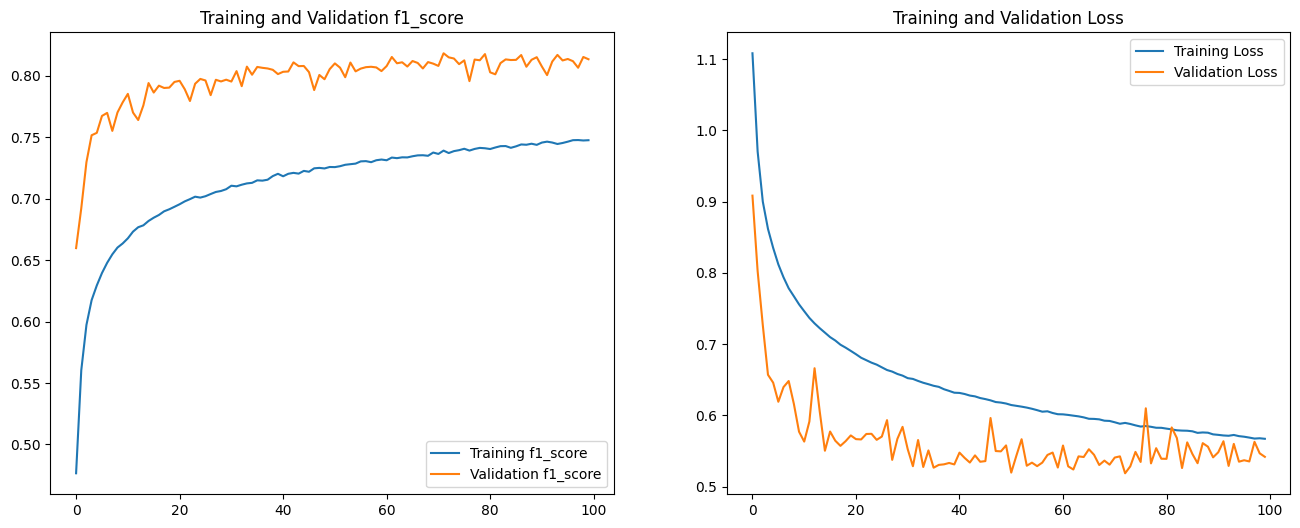

In [21]:
plot_history(trained_model[1],eps)

32/32 [==============================] - 0s 2ms/step
0.6344193382233354


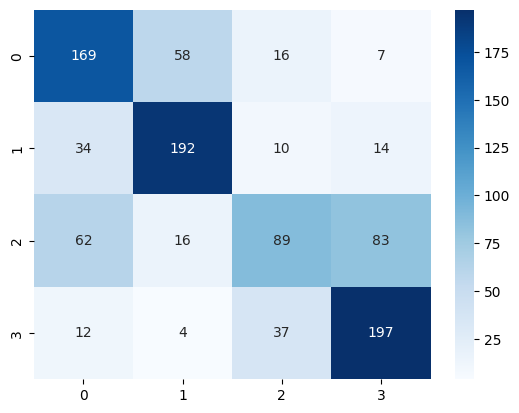

In [22]:
import seaborn as sns
# Wyświetlamy macierz pomyłek
score_f1 = evaluate_model(test_x_norm, test_y_one_hot, trained_model[0])

## 5) Podsumowanie i wnioski
Ostateczny wynik F1-score wyniósł około 0.634 co nie jest specjalnie dobrym wynikiem. Przetestowaliśmy wiele różnych architektur modelu, różne sposoby augmentacji, balansowania klas oraz one-hot encoding. Wszystkie te metody poprawiły nasze średnie wyniki eksperymentów, jednak nie udało nam się przekroczyć końcowego F1-score. Najbardziej problematyczną okazała się trzecia klasa jak widać na powyższej macierzy pomyłek. Bardzo możliwe, że augmentacja danych mogła by zostać wykonana w inny sposób i dzięki temu pomóc bardziej - jednak nie jesteśmy pewni jak bardzo powinniśmy zmieniać te dane, żeby zbytnio ich nie zniekształcić, być może była by tu potrzebna wiedza ekspercka lub głębsza analiza tych danych. Oprócz przedstawionej metody testowaliśmy również intensywnie drzewa losowe, jednak nie przyniosły one oczekiwanych rezultatów. Na wykresach widać duże wahania wartości straty (loss) i wyniku F1 na zbiorze walidacyjnym. Widać również, że zbiór walidacyjny osiąga lepsze wyniki w porównaniu do wyników na zbiorze treningowym. Może to być spowodowane zastosowaniem augmentacji danych lub obecnością prostszych obrazów w zbiorze walidacyjnym, które są łatwiejsze do sklasyfikowania.